In [1]:
# SE PUEDE OMITIR ESTA CELDA. En ese caso modificar path de carpetas
# que contienen las bases de datos de Arterias Coronarias y Retinas. (Imagenes -> Angiogramas, Imagenes -> retina)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Código auxiliar de la Tarea 1

## Funciones auxiliares

### Funciones para el manejo de archivos

In [2]:
import os

def names_generator(n_names=1, s='', format='.pgm', flag=False):
    """
    Generador de nombres de archivos {i.format}, i=1,...,n_images.
    Args:
        n_names (int): Cantidad de nombres a generar.
        s (string): Cadena extra que se quiera agregar al nombre.
        format (string): Formato del archivo.
    Ejemplos:
        names_generator(5) = ('1.pgm', '2.pgm', '3.pgm', '4.pgm', '5.pgm')
        names_generator(2, '_gt', 'jpg') = ('1_gt.jpg', '2_gt.jpg')
        names_generator(2, '_gt') = ('1_gt.pgm', '2_gt.pgm')
        names_generator() = ('1.pgm')
    """
    names = range(n_names)
    for name in names:
        path = ''
        if name < 9 and flag:
            path =  '0'
        path += str(name + 1) + s + format
        yield path

def get_names_from_path(path):    
    """
    Regresa nombres de archivos eel directorio getcwd() + path
    """
    # Obtenemos directorio de la carpeta con archivos
    dataset_dir = os.path.abspath(os.getcwd()) + path
    # Obtenemos lista de archivos
    names = os.listdir(dataset_dir)
    return names

### Funciones para visualización de imágenes

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def print_images(images, n=1, m=1, title=''):
    """
    Imprime las imagenes con su correspondiente titulo en un grid de n por m
    Args:
        images (list(np.ndarray)): Imagenes a imprimir.
        n (int): Cantidad de filas.
        m (int): Cantidad de columnas.
    """
    images = images[:n*m]
    fig, axs = plt.subplots(
        nrows=n, ncols=m, 
        figsize=(12, 8), 
        subplot_kw={
            'xticks': [], 
            'yticks': []
        }
    )
    for ax, image in zip(axs.flat, images):
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

def print_graphs(graphs, n=1, m=1, title=''):
    """
    Imprime las graficas con su correspondiente titulo en un grid de n por m
    Args:
        graphs (list(np.ndarray)): Graficas a imprimir.
        n (int): Cantidad de filas.
        m (int): Cantidad de columnas.
    """
    graphs = graphs[:n*m]
    fig, axs = plt.subplots(
        nrows=n, ncols=m, 
        figsize=(12, 8), 
    )
    for ax, graph in zip(axs.flat, graphs):
        ax.plot(graph)#, cmap='gray')
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

## Métodos de Umbralización

* Ridler Calvard
* Moment Preserving

### Ridler Calvard

In [4]:
def ridler_calvard(image, steps = 16):
    """
    Metodo de Umbralizacion Ridler-Calvard
    Args:
        image (np.ndarray): Imagen a segmentar
        steps (int): Numero de veces a iterar
    
    # Normalizacion de la imagen
    image = cv2.normalize(
        image, None, 
        alpha=0, beta=1, 
        norm_type=cv2.NORM_MINMAX, 
        dtype=cv2.CV_32F
    )
    """
    # 1. Seleccionamos un valor inicial de T
    T = np.mean(image)
    while steps > 0:
        # 2. Segmentamos imagen usando T
        ret, thresh = cv2.threshold(
            image, T, 255,
            cv2.THRESH_BINARY
        )
        # 3. Obtenemos dos clases de pixeles B y F
        B = image[np.where(thresh == 0)]
        F = image[np.where(thresh == 255)]
        # 4. Calculamos intensidades medias
        mu_B, mu_F = np.mean(B), np.mean(F)
        # 5. Actualizamos T
        T = np.mean([mu_B, mu_F])
        steps -= 1    
    #print("T : " + str(T))
    # 6. Usamos T final para umbralizar
    ret, thresh = cv2.threshold(
        image, T, 255,
        cv2.THRESH_BINARY
    )
    return thresh

### Moment Preserving
Se considera la imagen de nivel de gris como la versión borrosa de una imagen binaria ideal. El umbral se establece de modo que los tres primeros momentos del nivel de grises coincidan con los tres primeros momentos de la imagen binaria. Los momentos de nivel de gris y los momentos de imagen binaria bk se definen, respectivamente, como:
$$
    m_k = \sum_{g} p(g)g^{k}\\
    b_k = P_{f}m_{f}^{k} + P_{b}m_{b}^{k}
$$

In [5]:
def calculate_t(image):

    n = image.shape[0]*image.shape[1]

    # Calculo de histograma normalizado
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.sum()

    # Calculo de momentos
    m_i = [1.0, 0.0, 0.0, 0.0]
    for j, p_j in enumerate(hist_norm):
        for i in range(1, 4):
            m_i[i] += p_j * (j ** i)

    # Calculo de soluciones a c_0 y c_1
    c_d = np.linalg.det(np.array([
        [m_i[0], m_i[1]],
        [m_i[1], m_i[2]]
    ]))

    c_0 = np.linalg.det(np.array([
        [-m_i[2], m_i[1]],
        [-m_i[3], m_i[2]]
    ]))
    c_0 *= (1 / c_d)

    c_1 = np.linalg.det(np.array([
        [m_i[0], -m_i[2]],
        [m_i[1], -m_i[3]]
    ]))
    c_1 *= (1 / c_d)

    # Calculo de soluciones a z_0 y z_1
    z_0 = (0.5) * (-c_1 - np.sqrt(c_1**2 - 4*c_0))
    z_1 = (0.5) * (-c_1 + np.sqrt(c_1**2 - 4*c_0))
    
    # Calculo de soluciones de p_0 y p_1
    p_d = np.linalg.det(np.array([
        [1.0, 1.0],
        [z_0, z_1]
    ]))

    p_0 = np.linalg.det(np.array([
        [   1.0, 1.0],
        [m_i[1], z_1]
    ]))
    p_0 *= (1 / p_d)
    p_1 = 1 - p_0

    # Calculamos T
    t = np.quantile(image, p_0)
    
    return t

def moment_preserving(image):

    # 1. Calculamos T que preserva primeros 3 momentos
    T = calculate_t(image)
    #print("T: " + str(T))
    # 2. Usamos T final para umbralizar
    ret, thresh = cv2.threshold(
        image, T, 255,
        cv2.THRESH_BINARY
    )
    return thresh

# Gaussian Matched Filter

In [6]:
import numpy as np
import cv2
"""
def conv2D(window, kernel):
    rows, cols = kernel.shape
    val = 0.0
    for i in range(rows):
        for j in range(cols):
            val += window[i,j] * kernel[i,j]
    return val

def tophat(image, erosion_size = 3, erosion_shape=cv2.MORPH_RECT):
    element = cv2.getStructuringElement(
        erosion_shape, 
        (2 * erosion_size + 1, 2 * erosion_size + 1),
        (erosion_size, erosion_size)
    )
    erosion_dst = cv2.erode(image, element)
    ans = cv2.dilate(erosion_dst, element)
    return ans
"""
def gmf_chaudhuri(image, L=9, sigma=2.0, T=13, k=12, display_filters=False, TH=13):
    """
    Gaussian Matched Filter

    Args (Definimos los valores propuestos en el paper)
        L (int): Longitud del vaso
        sigma (float): Amplitud
        T (int): Corte de Gaussiana
        k (int): Numero de rotaciones 

        display_filters (boolean): Indica a la funcion si debe imprimir 
                                   banco de filtros
        TH (int): Tamanio del Elemento Estructurante para TopHat 
    """
    # 0. Normalizacion de pixeles
    """
    vmin = image.min()
    vmax = image.max()
    image = (np.float32(image) - vmin) / (vmax - vmin)
    """
    # 1. Suavizado con un filtro medio de 5x5 para reducir el efecto del ruido
    #    ademas de ayudar a TopHat para el contraste
    image = cv2.blur(image, (5, 5))
    """
    plt.imshow(image, vmin=0.0, vmax=1.0, cmap='gray')
    plt.show()
    """
    # (2). Mejora de contraste de las arterias (Esto no era parte del paper original)
    kernel_TH = np.ones((TH,TH))
    image = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel_TH)
    """
    plt.imshow(image, cmap='gray')
    plt.show()
    """
    # 3. GMF

    # Se obtienen k angulos de rotacion equiespaciados
    thetas = np.linspace(start=0, stop=180, num=k, endpoint=False)
    thetas = np.radians(thetas)
    
    # Dominio espacial de rotaciones
    m = max( (T - 1)/2, np.ceil(3*sigma) )
    x, y = np.meshgrid(
        np.arange(-m, m+1),
        np.arange(-m, m+1)
    )

    # Inicializamos con ceros imagen filtrada
    # ans = np.ones(image.shape) * (-100000)
    ans = np.zeros(image.shape) 
    
    kerneles = []
    for t in thetas:
        # Sistema de coordenadas rotado
        u = np.cos(t) * x - np.sin(t) * y
        v = np.sin(t) * x + np.cos(t) * y 
        
        # Construccion de kernel
        kernel = -np.exp( -(u ** 2) / (2 * (sigma ** 2)) )
        
        # Encontramos posiciones fuera del dominio
        u_indices = np.argwhere(abs(u) > 3*sigma)
        v_indices = np.argwhere(abs(v) > L/2)
        # Asignamos valor de 0 a posiciones fuera del dominio
        for idx in u_indices : kernel[idx[0], idx[1]] = 0
        for idx in v_indices : kernel[idx[0], idx[1]] = 0
        # Kernel con valor medio es positivo, se ven obligados 
        # a tener valores medios ligeramente negativos para reducir
        # el efecto del ruido de fondo cuando no hay vasos sanguíneos
        mean = np.mean(kernel)
        if mean > 0.0:
            mean = -mean
        kernel = kernel - mean     
        # Volvemos a asignar valor de 0 a posiciones fuera del dominio
        for idx in u_indices : kernel[idx[0], idx[1]] = 0
        for idx in v_indices : kernel[idx[0], idx[1]] = 0
        
        # Los coeficientes en el kernel deben ser números 
        # enteros en el rango (-128, 127)
        kernel *= 10
        kernel = np.around(kernel)
        
        # ¿El Kernel depende de la region de convolucion? 
        #   A*(1 - k * exp( - d**2 / 2 * a**2 ) )
        filtered_image = cv2.filter2D(image, -1, kernel)
        kerneles.append(kernel)

        """
        # Observamos la respuesta para cada filtro ...
        plt.imshow(
            filtered_image, vmin=filtered_image.min(), 
            vmax=filtered_image.max(), cmap='gray'
        )
        plt.show()
        """

        for i in range(ans.shape[0]):
            for j in range(ans.shape[1]):
                ans[i,j] = max(ans[i,j], filtered_image[i,j])
                # Nota: Esta inicializado en 0's, y podrian quedar
                # valores negativos por la forma de los filtros, por
                # lo que indirectamente estaria truncando valores negativos

    if display_filters : 
        # Mostramos algunos filtros en forma de imagenes y de matrices
        print_images(kerneles, 1, 5)
        print("")
        print(kerneles[0])
        print("")
        print(kerneles[1])

    """
    vmin = ans.min()
    vmax = ans.max()
    ans = (np.float32(ans) - vmin) / (vmax - vmin)    
    ans *= 255
    # Aplicamos un metodo de Umbralizacion
    ans = moment_preserving(ans)
    """
    return np.array(ans, dtype=np.uint8)

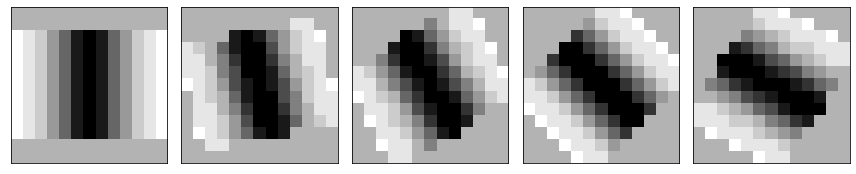


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 3.  2.  1. -1. -3. -6. -7. -6. -3. -1.  1.  2.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0.  2.  2.  0.  0.]
 [ 0.  0.  0.  0. -6. -7. -6. -3. -1.  1.  2.  3.  0.]
 [ 2.  1. -0. -3. -6. -7. -7. -4. -1.  1.  2.  2.  0.]
 [ 2.  2.  0. -2. -5. -7. -7. -5. -2.  0.  2.  2.  0.]
 [ 2.  

"\nplt.imshow(filtered, cmap='gray')\nplt.show()\n"

In [7]:
img = np.ones((20, 20), dtype=np.uint8) * 100
img[10,10] = 0
img[5,5] = 100

filtered = gmf_chaudhuri(img, L=9, sigma=2.0, T=13, k=12, display_filters=True, TH=19)
"""
plt.imshow(filtered, cmap='gray')
plt.show()
"""

# Imágenes

## Librerias usadas para manejo de imagenes

In [8]:
# Funciones para manejo de imagenes
import cv2
# Acceso a directorios de imagenes
import sys, os

In [9]:
"""
dataset_dir = os.path.abspath(os.getcwd())# + '/images'
names = os.listdir(dataset_dir)
print(names)
"""

"\ndataset_dir = os.path.abspath(os.getcwd())# + '/images'\nnames = os.listdir(dataset_dir)\nprint(names)\n"

## Angiogramas Coronarios de Rayos X
La actual base de datos (DCA1) consta de 134 angiogramas coronarios de rayos X y su correspondiente imagen Ground-Truth esbozada por un cardiólogo experto. Cada angiograma es una imagen en escala de grises de 300 x 300 píxeles en formato pgm (mapa de grises portátil).

### Lectura de imágenes

In [10]:
# Nos ubicamos en el directorio de las imagenes
os.chdir("/content/drive/My Drive/Colab Notebooks/data/Database_134_Angiograms/") # (SE PUDE MODIFICAR PARA REVISION)
# Numero de imagenes a procesar/imprimir
n_images = 5
# Generamos los nombres de las imagenes
file_path = names_generator(n_images)

images = []
for path in file_path:
    print(path)
    # Lectura de la imagen
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # Convertimos al negativo de la imagen
    """
    image = cv2.bitwise_not(image)
    """
    # Agregamos imagen a lista de imagenes
    images.append(image)

1.pgm
2.pgm
3.pgm
4.pgm
5.pgm


### Filtrando imágenes

Imagenes Originales


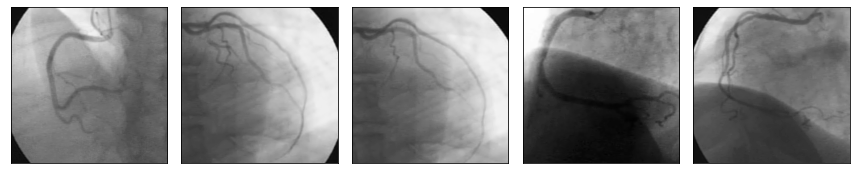

Imagenes Filtradas


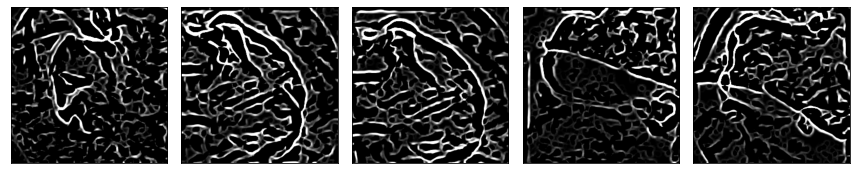

Umbralizacion MP de imagenes filtradas con GMF


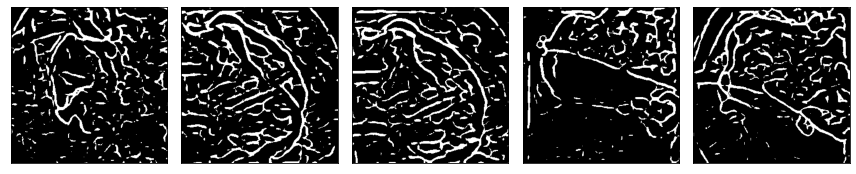

Umbralizacion MP de imagenes filtradas sin GMF


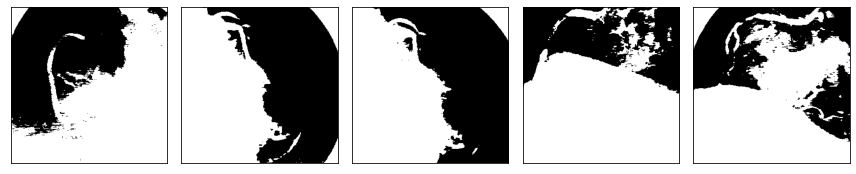

In [11]:
print("Imagenes Originales")
print_images(images[0:n_images], 1, n_images)

print("Imagenes Filtradas")
filtered_images = []
for image in images:
    filtered_image = gmf_chaudhuri(image, L=9, sigma=2.0, T=13, k=12, display_filters=False, TH=19)
    filtered_images.append(filtered_image)
print_images(filtered_images[0:n_images], 1, n_images)

print("Umbralizacion MP de imagenes filtradas con GMF")
threshold_filtered_images = []
for filtered_image in filtered_images[0:n_images]:
    filtered_image = moment_preserving(filtered_image)
    threshold_filtered_images.append(filtered_image)
print_images(threshold_filtered_images[0:n_images], 1, n_images)

print("Umbralizacion MP de imagenes filtradas sin GMF")
threshold_images = []
for image in images[0:n_images]:
    threshold_image = moment_preserving(image)
    threshold_images.append(255 - threshold_image)
print_images(threshold_images[0:n_images], 1, n_images)

### G.T. de imágenes

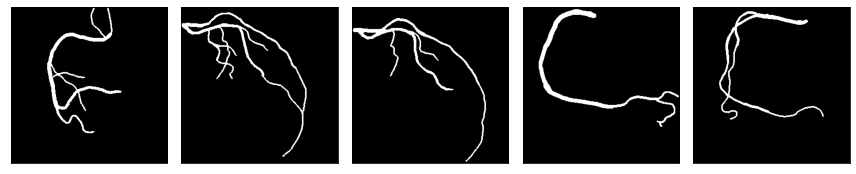

In [12]:
file_path = names_generator(n_images, '_gt')

images_gt = []
for path in file_path:
    # Lectura de la imagen
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # Agregamos imagen a lista de imagenes
    images_gt.append(image)

# Verificamos correcta binarizacion.
for i, image_gt in enumerate(images_gt):
    aux = dict({})
    for row in image_gt:
        for element in row:
            aux[str(element)] = 1
    if len(aux) != 2:
        print("G_T no binario con indice: " + str(i))

print_images(images_gt[0:n_images], 1, n_images)

### Histogramas

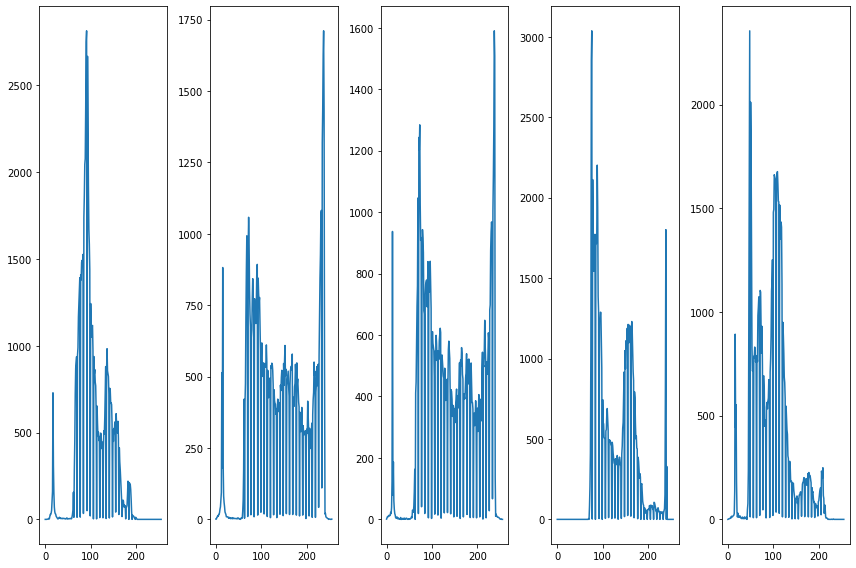

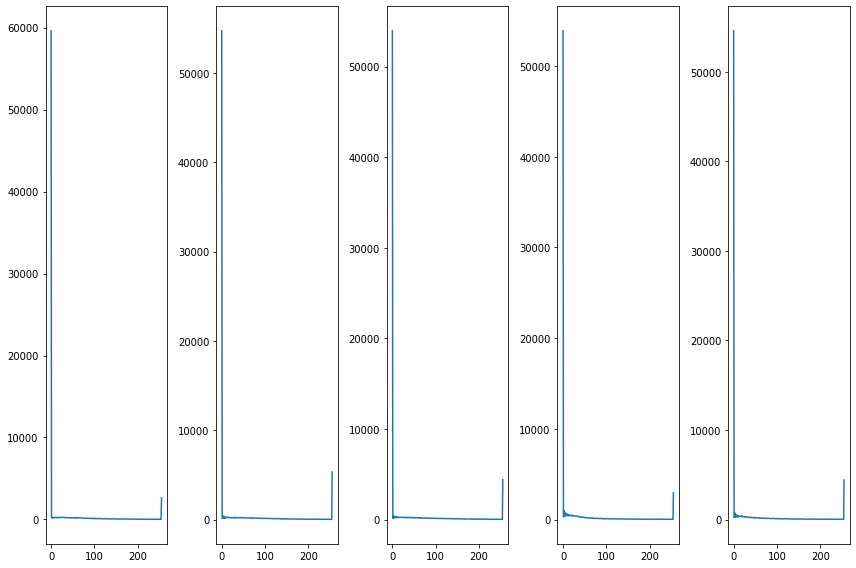

In [13]:
histograms = []
for image in images:    
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    histograms.append(hist)
print_graphs(histograms[0:n_images], 1, n_images)

histograms_filtered = []
for filtered_image in filtered_images:    
    hist = cv2.calcHist([filtered_image],[0],None,[256],[0,256])
    histograms_filtered.append(hist)
print_graphs(histograms_filtered[0:n_images], 1, n_images)

## Imágenes de Retina
Esta base de datos consta de 40 imágenes de retina y sus correspondiente Ground-Truth. Cada imagen está en escala __RGB__ de 584 x 565 píxeles en formato tif. 

### Lectura de imagenes.
Se deberia modificar el directorio para su poder volver a reproducir.

In [14]:
# Nos ubicamos en el directorio de las imagenes 
os.chdir("/content/drive/My Drive/Colab Notebooks/data/DRIVE_retina/test/images") # (SE PUDE MODIFICAR PARA REVISION)
# Numero de imagenes a procesar/imprimir
n_images = 20
# Generamos los nombres de las imagenes
file_path = names_generator(n_names=n_images, s=' test', format='.tif', flag=True)

images = []
for path in file_path:
    print(path)
    # Lectura de la imagen
    image = cv2.imread(
        path, 
        cv2.IMREAD_COLOR
    )
    # Separamos canales, nos interesa el componente con mejor contraste (Verde)
    b,g,r = cv2.split(image)
    """
    print(g.mean())
    # El fondo al rededor de la imagen es negro, lo cambiamos
    g[ g < 30] = 200
    """
    image = g
    # Convertimos al negativo de la imagen
    #image = cv2.bitwise_not(image)
    # Agregamos imagen a lista de imagenes 
    images.append(image)

01 test.tif
02 test.tif
03 test.tif
04 test.tif
05 test.tif
06 test.tif
07 test.tif
08 test.tif
09 test.tif
10 test.tif
11 test.tif
12 test.tif
13 test.tif
14 test.tif
15 test.tif
16 test.tif
17 test.tif
18 test.tif
19 test.tif
20 test.tif


### Filtrando imágenes

Imagenes Originales


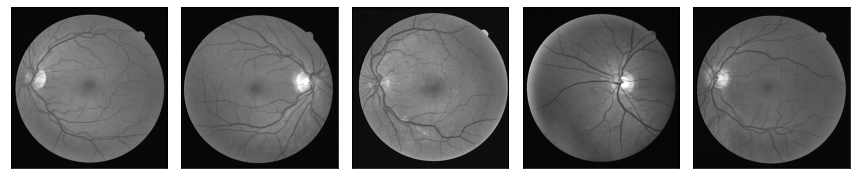

Imagenes Filtradas


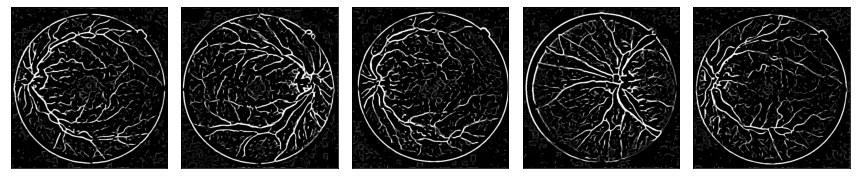

Umbralizacion MP de imagenes filtradas con GMF


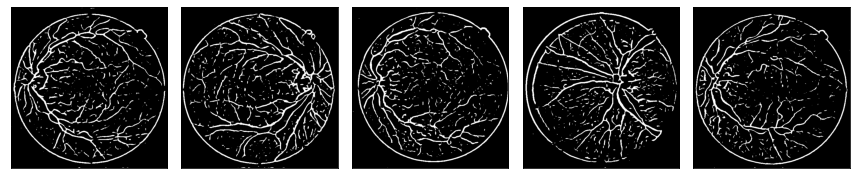

Umbralizacion MP de imagenes filtradas sin GMF


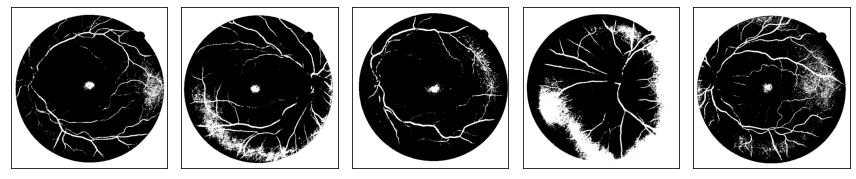

In [15]:
# Numero de imagenes a imprimir resultados
n_print = 5

print("Imagenes Originales")
print_images(images[0:n_print], 1, n_print)

print("Imagenes Filtradas")
filtered_images = []
for image in images:
    filtered_image = gmf_chaudhuri(image, L=9, sigma=2.0, T=13, k=12, display_filters=False, TH=19)
    filtered_images.append(filtered_image)
print_images(filtered_images[0:n_print], 1, n_print)

print("Umbralizacion MP de imagenes filtradas con GMF")
MP_threshold_filtered_images = []
for filtered_image in filtered_images:
    filtered_image = moment_preserving(filtered_image)
    MP_threshold_filtered_images.append(filtered_image)
print_images(MP_threshold_filtered_images[0:n_print], 1, n_print)

print("Umbralizacion MP de imagenes filtradas sin GMF")
MP_threshold_images = []
for image in images:
    threshold_image = moment_preserving(image)
    threshold_image = 255 - threshold_image
    MP_threshold_images.append(threshold_image)
print_images(MP_threshold_images[0:n_print], 1, n_print)

Imagenes Originales


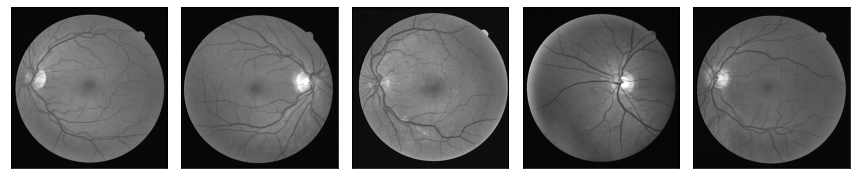

Imagenes Filtradas


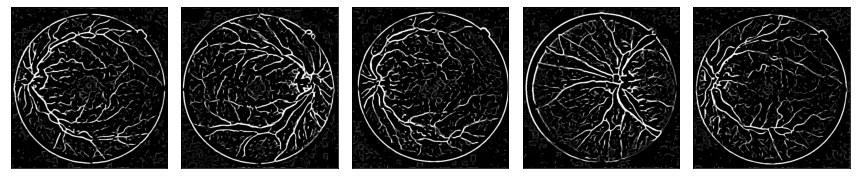

Umbralizacion Rid-Cal de imagenes filtradas con GMF


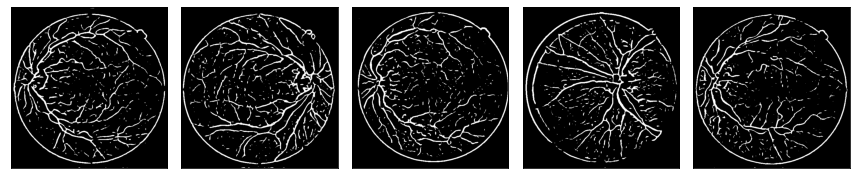

Umbralizacion Rid-Cal de imagenes filtradas sin GMF


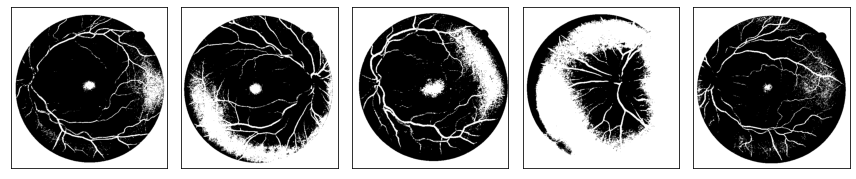

In [16]:
print("Imagenes Originales")
print_images(images[0:n_print], 1, n_print)
print("Imagenes Filtradas")
print_images(filtered_images[0:n_print], 1, n_print)

print("Umbralizacion Rid-Cal de imagenes filtradas con GMF")
RC_threshold_filtered_images = []
for filtered_image in filtered_images:
    filtered_image = ridler_calvard(filtered_image)
    RC_threshold_filtered_images.append(filtered_image)
print_images(RC_threshold_filtered_images[0:n_print], 1, n_print)

print("Umbralizacion Rid-Cal de imagenes filtradas sin GMF")
RC_threshold_images = []
for image in images:
    # Asignamos el color del borde exterior a un valor parecido al fondo del ojo. 
    image[image < 30] = image.mean()
    threshold_image = ridler_calvard(image)
    threshold_image = 255 - threshold_image
    RC_threshold_images.append(threshold_image)
print_images(RC_threshold_images[0:n_print], 1, n_print)

### G.T. de imagenes

01_manual1.gif
02_manual1.gif
03_manual1.gif
04_manual1.gif
05_manual1.gif
06_manual1.gif
07_manual1.gif
08_manual1.gif
09_manual1.gif
10_manual1.gif
11_manual1.gif
12_manual1.gif
13_manual1.gif
14_manual1.gif
15_manual1.gif
16_manual1.gif
17_manual1.gif
18_manual1.gif
19_manual1.gif
20_manual1.gif


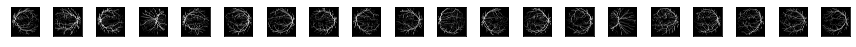

In [17]:
# Nos ubicamos en el directorio de las imagenes
os.chdir("/content/drive/My Drive/Colab Notebooks/data/DRIVE_retina/test/1st_manual")

file_path = names_generator(n_images, '_manual1', format='.gif', flag=True)

images_gt = []
for path in file_path:
    print(path)
    cap = cv2.VideoCapture(path)
    # Lectura de la imagen
    ret, image = cap.read()
    cap.release()
    if not ret : print("Error al abrir la imagen")
    # Separamos canales, nos interesa el componente con mejor contraste (Verde)
    b,g,r = cv2.split(image)
    image = g # En este caso cualquier canal puede ser usado
    # Agregamos imagen a lista de imagenes
    images_gt.append(image)

# Verificamos correcta binarizacion.
for i, image_gt in enumerate(images_gt):
    aux = dict({})
    for row in image_gt:
        for element in row:
            aux[str(element)] = 1
    if len(aux) != 2:
        print("G_T no binario con indice: " + str(i))

print_images(images_gt[0:n_images], 1, n_images)

### Histogramas de Imagenes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


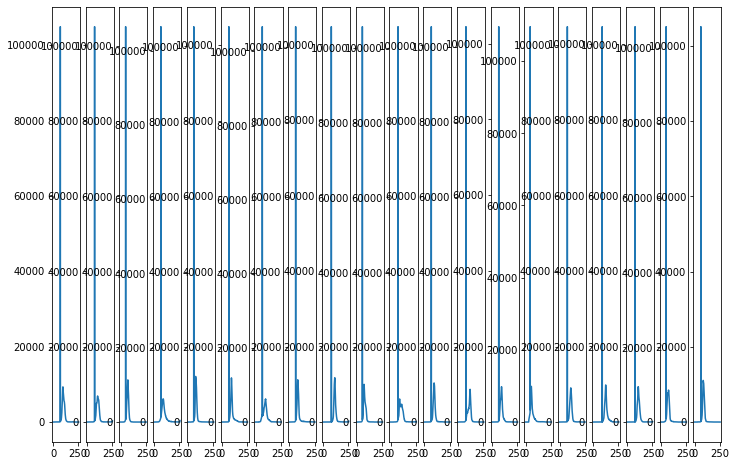

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


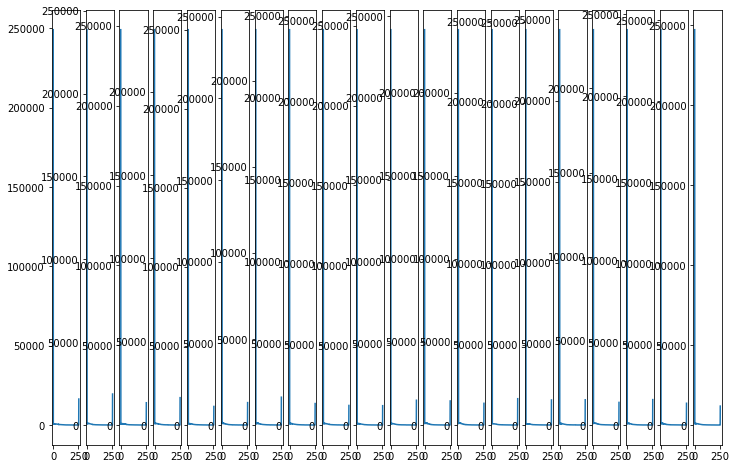

In [18]:
histograms = []
for image in images:    
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    histograms.append(hist)
print_graphs(histograms[0:n_images], 1, n_images)

histograms_filtered = []
for filtered_image in filtered_images:    
    hist = cv2.calcHist([filtered_image],[0],None,[256],[0,256])
    histograms_filtered.append(hist)
print_graphs(histograms_filtered[0:n_images], 1, n_images)

# Índices de Desempeño

## Funciones para cálculo de índices (Código de Tarea 1)

### Métricas

* Sensitivity
* Accuracy
* Misclassification error 
* Positive predictive value
* Negative predictive value
* Jaccard index
* Dicecoefficient

In [19]:
def sensitivity(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tp / (tp + fn)

def specificity(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tn / (tn + fp)

def accuracy(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return (tp + tn) / (tp + tn + fp + fn)

def misclassification_error(matrix):
    return 1 - accuracy(matrix)

def positive_predictive_value(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tp / (tp + fp)

def negative_predictive_value(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tn / (tn + fn)

def jaccard_index(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return tp / (tp + fp + fn)

def dice_coefficient(matrix):
    tn, fp, fn, tp = matrix.ravel()
    return (2*tp) / ( 2*tp + fp + fn)

### Funciones auxiliares

In [20]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(image_gt, image_si):
    
    y_true = image_gt.reshape(-1)
    y_pred = image_si.reshape(-1)

    matrix = confusion_matrix(y_true, y_pred, labels=[0, 255])

    return matrix

In [21]:
def performance_indices(images_gt, images_si):
    
    sensitivity_list = []
    specificity_list = []
    accuracy_list = []
    misclassification_list = []
    ppv_list = []
    npv_list = []
    jaccard_list = []
    dice_list = []

    for i, (image_gt, image_si) in enumerate(zip(images_gt, images_si)):
        # Obtenemos tabla de clasificacion
        matrix = get_confusion_matrix(image_gt, image_si)
        # Metricas ...
        sensitivity_list.append(sensitivity(matrix))
        specificity_list.append(specificity(matrix))
        accuracy_list.append(accuracy(matrix))
        misclassification_list.append(misclassification_error(matrix))
        ppv_list.append(positive_predictive_value(matrix))
        npv_list.append(negative_predictive_value(matrix))
        jaccard_list.append(jaccard_index(matrix))
        dice_list.append(dice_coefficient(matrix))
    
    sensitivity_mean = np.mean(sensitivity_list)
    specificity_mean = np.mean(specificity_list)
    accuracy_mean = np.mean(accuracy_list)
    misclassification_mean = np.mean(misclassification_list)
    ppv_mean = np.mean(ppv_list)
    npv_mean = np.mean(npv_list)
    jaccard_mean = np.mean(jaccard_list)
    dice_mean = np.mean(dice_list)

    print("")
    print("Sensitivity : " + str(sensitivity_mean))
    print("Specificity : " + str(specificity_mean))
    print("Accuracy : " + str(accuracy_mean))
    print("Misclassification : " + str(misclassification_mean))
    print("PPV : " + str(ppv_mean))
    print("NPV : " + str(npv_mean))
    print("jaccard Index : " + str(jaccard_mean))
    print("Dice Coefficient: " + str(dice_mean))
    print("")

## Cálculo de índices de desempeño

In [27]:
print("Sin GMF. Umbralizado con Ridler Calvard:")
performance_indices(images_gt, RC_threshold_images)
print("Con GMF. Umbralizado con Ridler Calvard:")
performance_indices(images_gt, RC_threshold_filtered_images)

Sin GMF. Umbralizado con Ridler Calvard:

Sensitivity : 0.49672534578560174
Specificity : 0.5221419100202334
Accuracy : 0.5196548066432294
Misclassification : 0.48034519335677056
PPV : 0.0906546571900589
NPV : 0.9145733449076859
jaccard Index : 0.08253695401786842
Dice Coefficient: 0.15203562463128956

Con GMF. Umbralizado con Ridler Calvard:

Sensitivity : 0.5061505105278001
Specificity : 0.951365273395362
Accuracy : 0.9122078433749545
Misclassification : 0.08779215662504546
PPV : 0.5008295309493164
NPV : 0.9523931497989084
jaccard Index : 0.33497116956878326
Dice Coefficient: 0.5013602570539125



In [23]:
print("Sin GMF. Umbralizado con Moment Preserving:")
performance_indices(images_gt, MP_threshold_images)
print("Con GMF. Umbralizado con Moment Preserving:")
performance_indices(images_gt, MP_threshold_filtered_images)

Sin GMF. Umbralizado con Moment Preserving:

Sensitivity : 0.39869230427587865
Specificity : 0.5814046950425202
Accuracy : 0.5648810461874165
Misclassification : 0.43511895381258336
PPV : 0.08286918011763775
NPV : 0.9097057631166683
jaccard Index : 0.07338577947867184
Dice Coefficient: 0.13639491608529372

Con GMF. Umbralizado con Moment Preserving:

Sensitivity : 0.5217902639982923
Specificity : 0.9475441008489593
Accuracy : 0.9100934961813554
Misclassification : 0.08990650381864469
PPV : 0.489111292095734
NPV : 0.953644415202912
jaccard Index : 0.33650150533688084
Dice Coefficient: 0.5030989460787774



In [26]:
len(MP_threshold_filtered_images)

20

# Experimentos

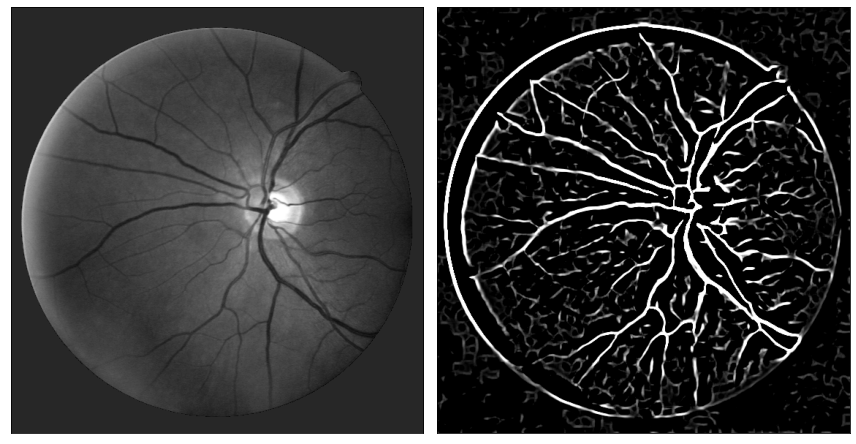

In [24]:
print_images([images[3], filtered_images[3]], 1, 2)

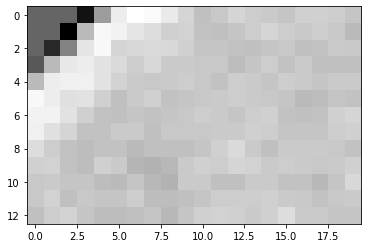

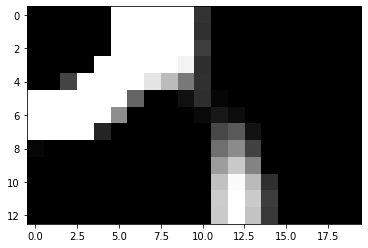

In [25]:
i, j = 100, 100
img = images[0][i+0:i+13, j+0:j+20]
plt.imshow(img, cmap='gray')
plt.show()

filtered = gmf_chaudhuri(255 - img, L=9, sigma=2.0, T=13, k=12, display_filters=False, TH=19)
plt.imshow(filtered, cmap='gray')
plt.show()